In [1]:
import numpy as np
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats import ttest_ind

import seaborn as sns

!pip install pydicom
from itertools import chain
from pydicom import dcmread
from skimage import io

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Defaulting to user installation because normal site-packages is not writeable


Using TensorFlow backend.


In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70142,00017266_003.png,Emphysema,3,17266,53,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017266_003.png
71938,00017719_005.png,No Finding,5,17719,19,F,PA,2544,3056,0.139,0.139,NaN,/data/images_008/images/00017719_005.png
5195,00001382_003.png,Nodule,3,1382,27,M,AP,2048,2500,0.168,0.168,NaN,/data/images_002/images/00001382_003.png


In [3]:
# clean df
df = all_xray_df.copy()
df.columns = df.columns.str.replace(' ', '_')
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]
df = df.iloc[:,0:7]
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 
df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
df.head(1)



,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png


In [4]:
## One Hot Encoding of the Finding Labels Column
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)

del df['Finding_Labels']
df.columns = df.columns.str.replace(' ', '_')

df.head(1)


,Image_Index,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0


Overall Data:
Male Patients: 63340
Female Patients: 48780
Male Proportion: 0.5649304316803425
Female Proportion: 0.4350695683196575
Standard Error: 0.0021117546425551414
Z-Statistic: 61.49429519120574
P-Value: 0.0

Pneumonia Patients:
Male Patients: 838
Female Patients: 593
Male Proportion: 0.5856044723969253
Female Proportion: 0.4143955276030748
Standard Error: 0.018692405136401476
Z-Statistic: 9.159278516836723
P-Value: 5.224544022823702e-20


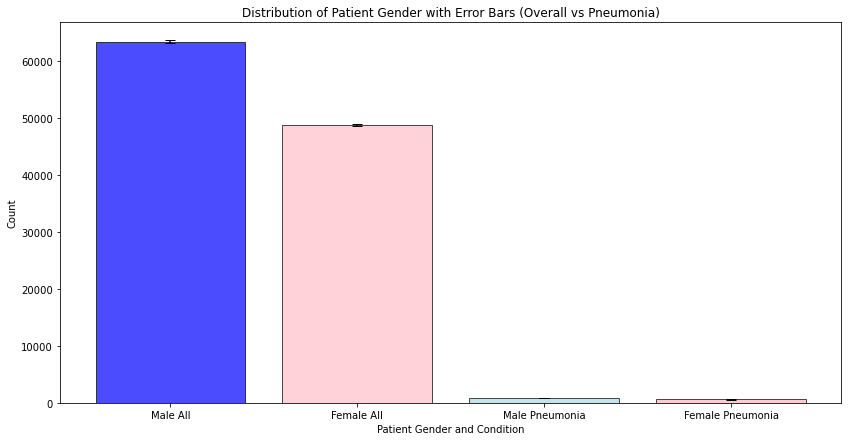

In [5]:
# Filter pneumonia patients
pneumonia_df = df[df['Pneumonia'] == 1]
non_pneumonia_df = df[df['Pneumonia'] == 0]

# Gender distribution for all data
male_patients_all = len(df[df.Patient_Gender == "M"])
female_patients_all = len(df[df.Patient_Gender == "F"])

# Gender distribution for pneumonia patients
male_patients_pneumonia = len(pneumonia_df[pneumonia_df.Patient_Gender == "M"])
female_patients_pneumonia = len(pneumonia_df[pneumonia_df.Patient_Gender == "F"])

# Calculate proportions
male_proportion_all = male_patients_all / (male_patients_all + female_patients_all)
female_proportion_all = female_patients_all / (male_patients_all + female_patients_all)

male_proportion_pneumonia = male_patients_pneumonia / (male_patients_pneumonia + female_patients_pneumonia)
female_proportion_pneumonia = female_patients_pneumonia / (male_patients_pneumonia + female_patients_pneumonia)

# Standard Error Calculation
total_patients_all = male_patients_all + female_patients_all
total_patients_pneumonia = male_patients_pneumonia + female_patients_pneumonia

pooled_proportion_all = (male_patients_all + female_patients_all) / (2 * total_patients_all)
pooled_proportion_pneumonia = (male_patients_pneumonia + female_patients_pneumonia) / (2 * total_patients_pneumonia)

se_all = np.sqrt(pooled_proportion_all * (1 - pooled_proportion_all) * (2 / total_patients_all))
se_pneumonia = np.sqrt(pooled_proportion_pneumonia * (1 - pooled_proportion_pneumonia) * (2 / total_patients_pneumonia))

# Z-Statistic and P-Value Calculation
z_stat_all = (male_proportion_all - female_proportion_all) / se_all
p_value_all = 2 * norm.cdf(-abs(z_stat_all))

z_stat_pneumonia = (male_proportion_pneumonia - female_proportion_pneumonia) / se_pneumonia
p_value_pneumonia = 2 * norm.cdf(-abs(z_stat_pneumonia))

# Print results
print("Overall Data:")
print("Male Patients:", male_patients_all)
print("Female Patients:", female_patients_all)
print("Male Proportion:", male_proportion_all)
print("Female Proportion:", female_proportion_all)
print("Standard Error:", se_all)
print("Z-Statistic:", z_stat_all)
print("P-Value:", p_value_all)

print("\nPneumonia Patients:")
print("Male Patients:", male_patients_pneumonia)
print("Female Patients:", female_patients_pneumonia)
print("Male Proportion:", male_proportion_pneumonia)
print("Female Proportion:", female_proportion_pneumonia)
print("Standard Error:", se_pneumonia)
print("Z-Statistic:", z_stat_pneumonia)
print("P-Value:", p_value_pneumonia)

# Plot Histogram with Error Bars
plt.figure(figsize=(14,7))

# Data for plotting
labels = ['Male All', 'Female All', 'Male Pneumonia', 'Female Pneumonia']
counts = [male_patients_all, female_patients_all, male_patients_pneumonia, female_patients_pneumonia]
errors = [np.sqrt(male_patients_all), np.sqrt(female_patients_all), np.sqrt(male_patients_pneumonia), np.sqrt(female_patients_pneumonia)]

# Plot bars
plt.bar(labels, counts, yerr=errors, capsize=5, color=['blue', 'pink', 'lightblue', 'lightpink'], alpha=0.7, edgecolor='black')

# Labels and Title
plt.xlabel('Patient Gender and Condition')
plt.ylabel('Count')
plt.title('Distribution of Patient Gender with Error Bars (Overall vs Pneumonia)')

plt.show()

# There are significantly more male patients in both overall and penumonia. 
# Although this could work in our favor as the dataset represented the real world data, 
# Where male are at higher risk to contract penumonia and are more likely to die from the disease, 
# According to American Lung Association. 

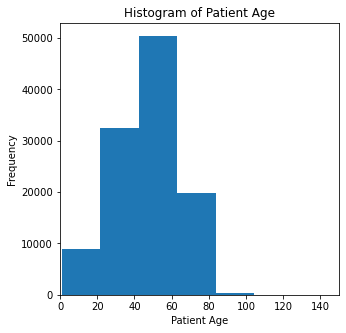

Maximum Age: 414
Patients Over 85 (before removal): 273
Patients Over 85 (after removal): 0


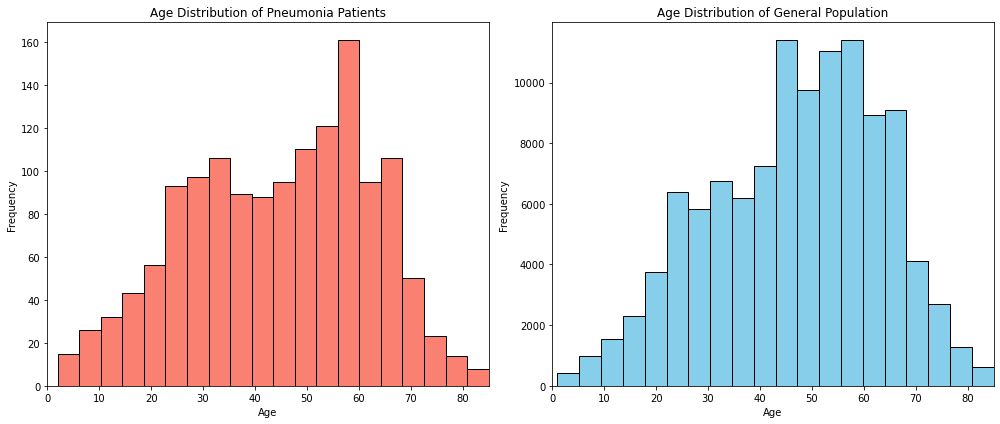

Pneumonia Patients: Mean Age = 44.609243697478995, Std Dev = 17.574826672660723
General Population: Mean Age = 46.77771419886094, Std Dev = 16.498345594316394
T-Statistic: -4.636572191118775
P-Value: 3.858901582967089e-06


In [6]:
# Plot histogram for Patient Age
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Age, bins=20)
plt.xlim(0, 150)  # Set x-axis limit to 150
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Histogram of Patient Age')
plt.show()

# Find the maximum age
max_age = np.max(df.Patient_Age)
print("Maximum Age:", max_age)

# Cut off any data above age 85
patients_over_85 = len(df[df.Patient_Age > 85])
print("Patients Over 85 (before removal):", patients_over_85)

df = df[df.Patient_Age <= 85]  # Filter out patients older than 85

patients_over_85 = len(df[df.Patient_Age > 85])
print("Patients Over 85 (after removal):", patients_over_85)

# Filter the pneumonia patients
pneumonia_patients_df = df[df['Pneumonia'] == 1]

# Plotting age distribution
plt.figure(figsize=(14, 6))

# Plot age distribution for Pneumonia Patients
plt.subplot(1, 2, 1)
plt.hist(pneumonia_patients_df.Patient_Age, bins=20, color='salmon', edgecolor='black')
plt.xlim(0, 85)  # Set x-axis limit to 85 years
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Pneumonia Patients')

# Plot age distribution for General Population
plt.subplot(1, 2, 2)
plt.hist(df.Patient_Age, bins=20, color='skyblue', edgecolor='black')
plt.xlim(0, 85)  # Set x-axis limit to 85 years
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of General Population')

plt.tight_layout()
plt.show()

# Calculate descriptive statistics
mean_age_pneumonia = pneumonia_patients_df['Patient_Age'].mean()
std_age_pneumonia = pneumonia_patients_df['Patient_Age'].std()
mean_age_general = df['Patient_Age'].mean()  # Use 'df' as the general population
std_age_general = df['Patient_Age'].std()

print(f"Pneumonia Patients: Mean Age = {mean_age_pneumonia}, Std Dev = {std_age_pneumonia}")
print(f"General Population: Mean Age = {mean_age_general}, Std Dev = {std_age_general}")

# Perform t-test
t_stat, p_value = ttest_ind(pneumonia_patients_df['Patient_Age'], df['Patient_Age'], equal_var=False)
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# The mean age of pneumonia patients is statistically significantly younger on average.

# Additional remarks:
# According to the World Health Organization (WHO), Pneumonia kills more than 808,000 children under the age of 5.
# People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems.
# Since there are less than 20 pneumonia patients under age 5, and not many after age 70,
# adding more weight to the model for these age groups may be beneficial.




PA: 67173
AP: 44674
PA Proportion: 0.6005793628796481
AP Proportion: 0.3994206371203519
Standard Error: 0.0021143302934681805
Z-Statistic: 95.14063454548119
P-Value: 0.0


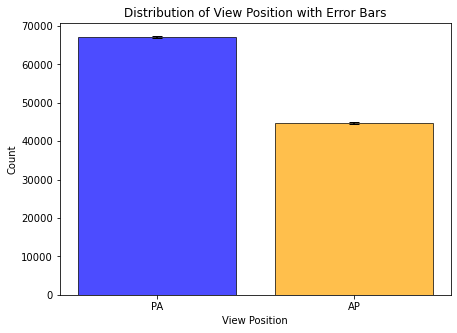

In [7]:
# Now position view. 
# Calculate counts
PA = len(df[df.View_Position == "PA"])
AP = len(df[df.View_Position == "AP"])

# Print counts
print("PA:", PA)
print("AP:", AP)

total_patients = PA + AP

# Calculate proportions
PA_proportion = PA / total_patients
AP_proportion = AP / total_patients

# Calculate standard error
pooled_proportion = (PA + AP) / (2 * total_patients)
se = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (2 / total_patients))

# Print proportions and standard error
print("PA Proportion:", PA_proportion)
print("AP Proportion:", AP_proportion)
print("Standard Error:", se)

# Calculate Z-statistic
z_stat = (PA_proportion - AP_proportion) / se

# Calculate p-value
p_value = 2 * norm.cdf(-abs(z_stat))

# Print Z-statistic and p-value
print("Z-Statistic:", z_stat)
print("P-Value:", p_value)

# Calculate errors for the plot (standard error * total patients for each group)
errors = [se * total_patients, se * total_patients]

# Data for plotting
labels = ['PA', 'AP']
counts = [PA, AP]

# Plot histogram with error bars
plt.figure(figsize=(7,5))
plt.bar(labels, counts, yerr=errors, capsize=5, color=['blue', 'orange'], alpha=0.7, edgecolor='black')
plt.xlabel('View Position')
plt.ylabel('Count')
plt.title('Distribution of View Position with Error Bars')
plt.show()


# The statistics implies that "PA" view positions are significantly more common than "AP" view positions in the dataset.
# Although there is no need to adjust the weights because in reality, chest radiographs are generally obtained PA 
# to minimize magnification of the cardiac silhouette (according to National Institutes of Health (NIH). 


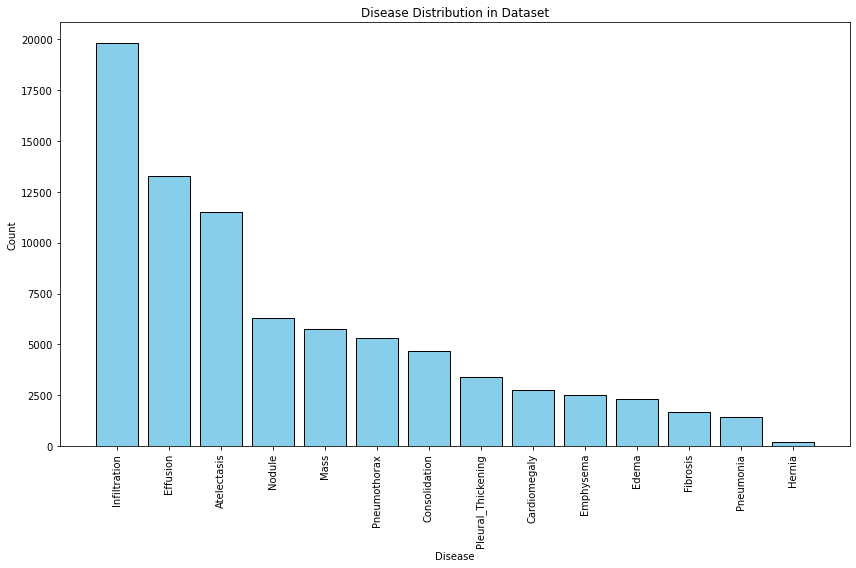

In [8]:
# Filter valid labels that are present in the DataFrame
valid_labels = [label for label in all_labels if label in df.columns]

# Calculate the number of each disease
disease_counts = df[valid_labels].sum().sort_values(ascending=False)

# Plot the disease distribution
plt.figure(figsize=(12, 8))
plt.bar(disease_counts.index, disease_counts.values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Disease Distribution in Dataset')
plt.tight_layout()
plt.show()

# Infiltration, Effusion, and Atelectasis are the most common diseases 
# in this dataset. 


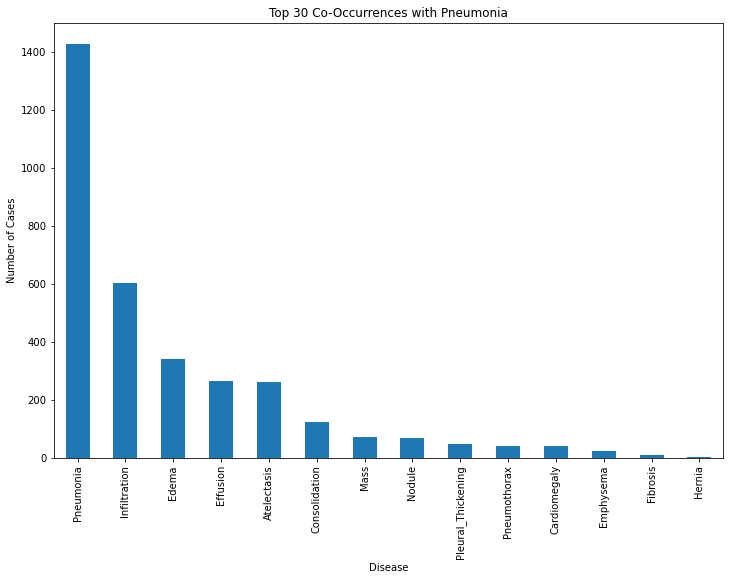

Pneumonia             1428
Infiltration           604
Edema                  340
Effusion               267
Atelectasis            262
Consolidation          123
Mass                    71
Nodule                  70
Pleural_Thickening      48
Pneumothorax            41
Cardiomegaly            41
Emphysema               23
Fibrosis                11
Hernia                   3
dtype: int64


In [9]:
# Focus on pneumonia and its co-occurrences
pneumonia_df = df[df['Pneumonia'] == 1]

# Calculate the co-occurrence of pneumonia with other diseases
co_occurrences = pneumonia_df[valid_labels].sum().sort_values(ascending=False)

# Select the top 30 co-occurrences
top_30_co_occurrences = co_occurrences.head(30)

# Plot the distribution of the top 30 co-occurrences
plt.figure(figsize=(12, 8))
top_30_co_occurrences.plot(kind='bar')
plt.title('Top 30 Co-Occurrences with Pneumonia')
plt.xlabel('Disease')
plt.ylabel('Number of Cases')
plt.xticks(rotation=90)
plt.show()

# Print the top 30 co-occurrences
print(top_30_co_occurrences)



# out of the top three most common co-occurrences: Infiltrates can be caused by pneumonia, Pulmonary edema can show diffuse or patchy opacities similar to those seen in pneumonia, 
# Effusion involves fluid in the pleural space, which can accompany pneumonia (parapneumonic effusion) and complicate the radiologic interpretation.
# Meaning, model could confuse other co-occurrences with Penumonia. 
# Thus, further interpretation by professional radiologist are crucial. 


Existing Labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


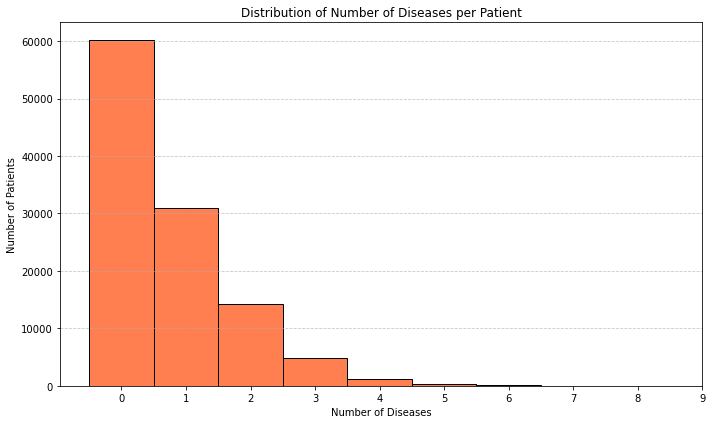

0    60247
1    30876
2    14255
3     4841
4     1242
5      300
6       67
7       16
8        1
9        2
Name: Num_Diseases, dtype: int64


In [10]:

# Ensure that columns exist in the DataFrame
existing_labels = [label for label in all_labels if label in df.columns]
print("Existing Labels:", existing_labels)

# Count number of diseases per patient
df['Num_Diseases'] = df[existing_labels].sum(axis=1)

# Plot the distribution of number of diseases per patient
plt.figure(figsize=(10, 6))
plt.hist(df['Num_Diseases'], bins=np.arange(df['Num_Diseases'].max() + 1) - 0.5, color='coral', edgecolor='black')
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Distribution of Number of Diseases per Patient')
plt.xticks(np.arange(df['Num_Diseases'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the number of patients in each disease count category for reference
disease_distribution = df['Num_Diseases'].value_counts().sort_index()
print(disease_distribution)


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                       

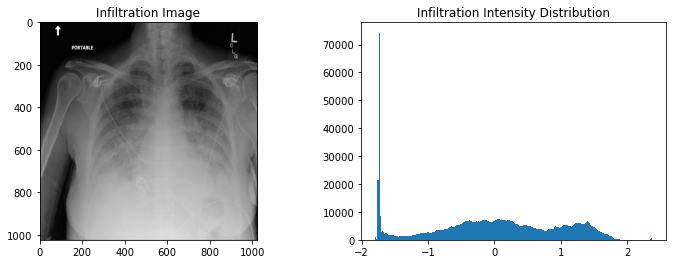

Processing Image for Edema: 00011702_026.png


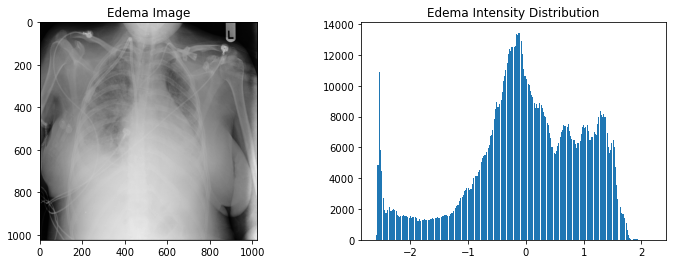

Processing Image for Effusion: 00003279_001.png


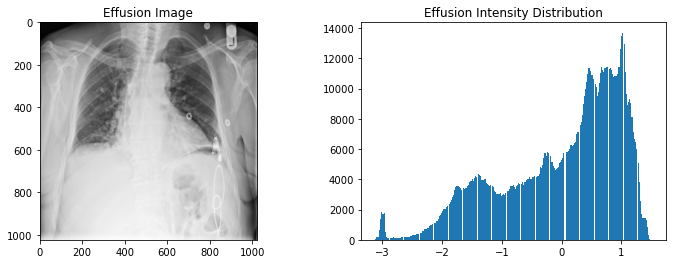

Processing Image for Atelectasis: 00008182_001.png


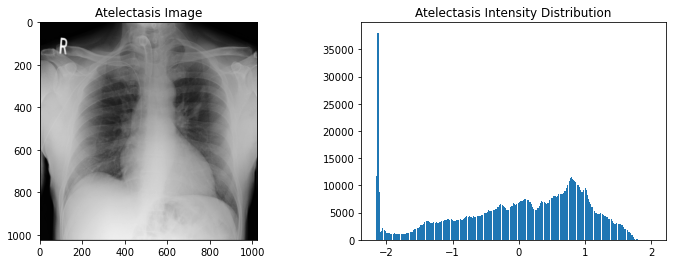

Processing Image for No Finding: 00006518_002.png


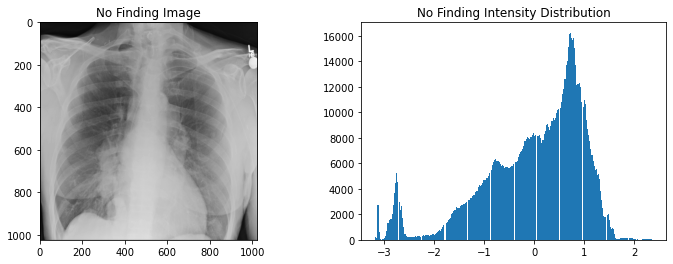

Processing Image for Pneumonia: 00028485_005.png


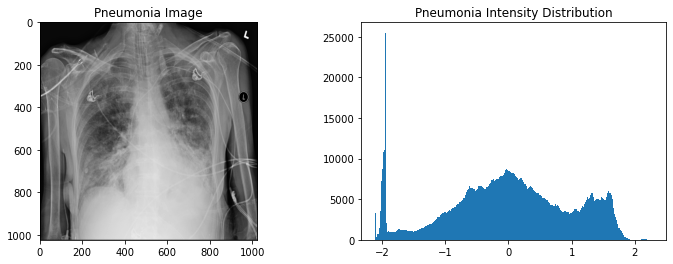

In [11]:
# Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(all_xray_df.head(3))

# Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print(sample_df.head(3))

df = all_xray_df.copy()

# Replace spaces in column names with underscores
df.columns = df.columns.str.replace(' ', '_')
print(df.head(1))

# Split the OriginalImage[Width Height] and OriginalImagePixelSpacing[x y] columns
OriginalImageWidth = df.iloc[:, 7]
OriginalImageHeight = df.iloc[:, 8]
OriginalImagePixelSpacing_x = df.iloc[:, 9]
OriginalImagePixelSpacing_y = df.iloc[:, 10]  # Correct index for y

# Select only the first seven columns without the image data
df = df.iloc[:, :7]

# Add the image data as new columns
df['OriginalImageWidth'] = OriginalImageWidth
df['OriginalImageHeight'] = OriginalImageHeight
df['OriginalImagePixelSpacing_x'] = OriginalImagePixelSpacing_x
df['OriginalImagePixelSpacing_y'] = OriginalImagePixelSpacing_y

print(df.head(1))


# Helper function to standardize the image
def standardize_image(imageData):
    mean_intensity = np.mean(imageData)
    std_intensity = np.std(imageData)
    new_img = imageData.copy()
    new_img = (new_img - mean_intensity) / std_intensity
    return new_img

# Helper function to print the image and the intensity distribution
def image_distribution(image, title_prefix):
    f = plt.figure()
    f.set_figwidth(12)
    
    # Standardize the image data
    image = standardize_image(image)
    
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title(f'{title_prefix} Image')
    plt.imshow(image, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title(f'{title_prefix} Intensity Distribution')
    plt.hist(image.ravel(), bins=256)
    
    plt.show()

# Get the images from the patients
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data', 'images*', '*', '*.png'))}

# Define conditions for various findings
conditions = ['Infiltration', 'Edema', 'Effusion', 'Atelectasis', 'No Finding', 'Pneumonia']

for condition in conditions:
    # Filter DataFrame based on the current condition
    condition_df = df[df['Finding_Labels'].str.contains(condition, na=False)]
    
    if not condition_df.empty:
        # Sample one image from the filtered DataFrame
        img = condition_df['Image_Index'].sample().item()
        print(f'Processing Image for {condition}:', img)
        
        if img in image_paths:
            img_path = image_paths[img]
            img_data = io.imread(img_path)
            image_distribution(img_data, condition)
        else:
            print(f"Warning: Image path for {img} not found.")
    else:
        print(f"No images found for condition: {condition}.")


In [ ]:
# Summary: 
# The dataset comprises a total of 112,120 chest X-rays, with 63,340 from male patients and 48,780 from female patients. Among these, there are 1,431 pneumonia cases (838 male and 593 female). However, after data cleaning, the number of pneumonia cases was slightly reduced to 1,428. The age distribution of patients was capped at 85 years due to a significant decline in patient numbers beyond this age and an unrealistic maximum age of 414, suggesting potential data entry errors. The mean age of the general patient population is 46.8 years, while the mean age of pneumonia patients is slightly younger at 44.6 years.

# The dataset reveals a higher prevalence of PA (posteroanterior) views (67,173) compared to AP (anteroposterior) views (44,674), reflecting the clinical practice where PA views are preferred to minimize cardiac silhouette magnification. Most patients in the dataset have two or fewer diseases, although there are rare cases with up to nine diseases.

# Pneumonia often co-occurs with conditions like Infiltration and Edema. The radiographic appearance of pneumonia, which typically manifests as darker lung areas compared to healthy tissue, can be difficult to distinguish from other conditions, especially for non-radiologists. In particular, infiltrates, pulmonary edema, and pleural effusion (which can be associated with pneumonia) complicate radiologic interpretation, highlighting the importance of expert radiologist input to avoid misclassification by automated models.

# Infiltration, Effusion, and Atelectasis are the most common diseases in this dataset. The predominance of PA views aligns with clinical standards, and thus, there is no immediate need to adjust the model's weighting for view positions.

# Pneumonia remains a significant health concern globally, particularly for vulnerable populations such as children under five and older adults. According to the World Health Organization (WHO), pneumonia claims over 808,000 children under five each year. The dataset reflects a lower incidence of pneumonia in children under five and in patients over 70, suggesting that model weighting for these age groups could be adjusted to improve sensitivity in these high-risk populations.

# Additionally, the data shows a higher prevalence of pneumonia among male patients, which is consistent with real-world data indicating that men are at a higher risk of contracting pneumonia and have higher mortality rates from the disease, according to the American Lung Association. This gender imbalance in the dataset may be advantageous as it mirrors the actual risk distribution in the population.

# This analysis underscores the need for careful consideration of demographic factors, disease co-occurrences, and clinical practices in developing and applying machine learning models for pneumonia detection.

